# Introduction
This is an in progress notebook that has been created to demonstrate processing and analysis of public transportation data. This is still in the early stages of development and will eventually incorporate machine learning techniques to predict patronage for bus stops in SEQ. At this stage, basic analysis is shown for demonstrative purposes.

The following data is used:
 - Translink public transport patronage data (January 2022 to August 2023)
 - Translink GTFS data
 - Locality boundaries spatial data

Future actions will involve looking into the incorporation of additional data such as route frequency, population catchment, economics, weather data etc. The intent is to investigate whether it will be possible to develop a tool that can predict the demand for new bus stops at given locations.

## Python Libraries
This analysis uses the following libraries:
 - Pandas for data wrangling and queries
 - Geopandas for spatial processing
 - Seaborn for aesthetics

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Set Seaborn style
sns.set(style="whitegrid")

## Loading and Inspecting the Data
The parquet file loaded has been created using patronage data scraped from the Queensland Open Data website. To view the script used to obtain this information, please visit https://github.com/alex-williams75/seq-pt/blob/main/pt-webscrape.py.

As seen below, there is sufficient information to identify how many trips occurred from one stop to another. However, understanding trips between suburbs will be of more use to better understand general travel trends on public transport. This can be achieved by loading in locality boundaries and undertaking spatial analysis to locate the stops within the boundaries.

In [2]:
# Load trip data
df_trips = pd.read_parquet('./data/SEQ_PT_Trips.parquet')
df_trips['quantity'] = df_trips['quantity'].astype(int)

# Load stop information and remove unnecessary columns
df_stops = pd.read_csv('./data/stops.txt')
df_stops['stop_code'] = pd.to_numeric(df_stops['stop_code'], errors='coerce').fillna(-1).astype(int)
df_stops = df_stops.iloc[:, :7]

In [3]:
df_trips

,operator,month,route,direction,time,ticket_type,origin_stop,destination_stop,quantity
0,Transport for Brisbane,2022-01,175,Outbound,Weekend,go card,10309,2232,1
1,Transport for Brisbane,2022-01,227,Outbound,Weekday (3:00pm-6:59:59pm),go card,228,1308,1
2,Transport for Brisbane,2022-01,227,Outbound,Weekday (3:00pm-6:59:59pm),go card,226,6126,4
3,Transport for Brisbane,2022-01,227,Outbound,Weekday (3:00pm-6:59:59pm),go card,226,6027,9
4,Transport for Brisbane,2022-01,227,Outbound,Weekday (3:00pm-6:59:59pm),go card,226,5914,2
...,...,...,...,...,...,...,...,...,...
8835758,Transport for Brisbane,2023-08,192,Outbound,Weekday (3:00pm-6:59:59pm),go card,36,1053,6
8835759,Transport for Brisbane,2023-08,192,Outbound,Weekday (3:00pm-6:59:59pm),go card,36,1051,78
8835760,Transport for Brisbane,2023-08,192,Outbound,Weekday (3:00pm-6:59:59pm),go card,36,1049,41
8835761,Transport for Brisbane,2023-08,192,Outbound,Weekday (3:00pm-6:59:59pm),go card,36,1128,5


In [4]:
df_stops

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id
0,1,1,Herschel Street Stop 1 near North Quay,NaN,-27.467834,153.019079,1
1,10,10,Ann Street Stop 10 at King George Square,NaN,-27.468003,153.023970,1
2,100,100,Parliament Stop 94A Margaret St,NaN,-27.473751,153.026745,1
3,1000,1000,Handford Rd at Songbird Way,NaN,-27.339069,153.043907,2
4,10000,10000,Balcara Ave near Allira Cr,NaN,-27.344106,153.024982,2
...,...,...,...,...,...,...,...
13025,place_pinesc,-1,The Pines Shopping Centre,NaN,-28.134660,153.469767,NaN
13026,place_inttbl,-1,Toombul Shopping Centre interchange,NaN,-27.408269,153.059963,NaN
13027,place_scuniv,-1,University of the Sunshine Coast station,NaN,-26.718756,153.062004,NaN
13028,place_intuq,-1,UQ Chancellors Place,NaN,-27.497970,153.011136,NaN


# Spatial Analysis
## Incorporating Localities
Using the coordinates provided in the stops dataset, GeoPandas can be used to complete a join query to understand what stops are in within which locality boundaries. The boundaries spatial file was also sourced from the Queensland Open Data portal.

In [5]:
# Creating a geodataframe from the stops data
geometry = [Point(lon, lat) for lon, lat in zip(df_stops['stop_lon'], df_stops['stop_lat'])]
gdf_stops = gpd.GeoDataFrame(df_stops, geometry=geometry)

# Loading locality shp file
gdf_locality = gpd.read_file("./spatial/Locality_Boundaries.shp")

The plot below shows the plotting of the stop locations and the boundaries. It appears to show the SEQ network correctly.

Text(147.58022097497565, 0.5, 'Latitude')

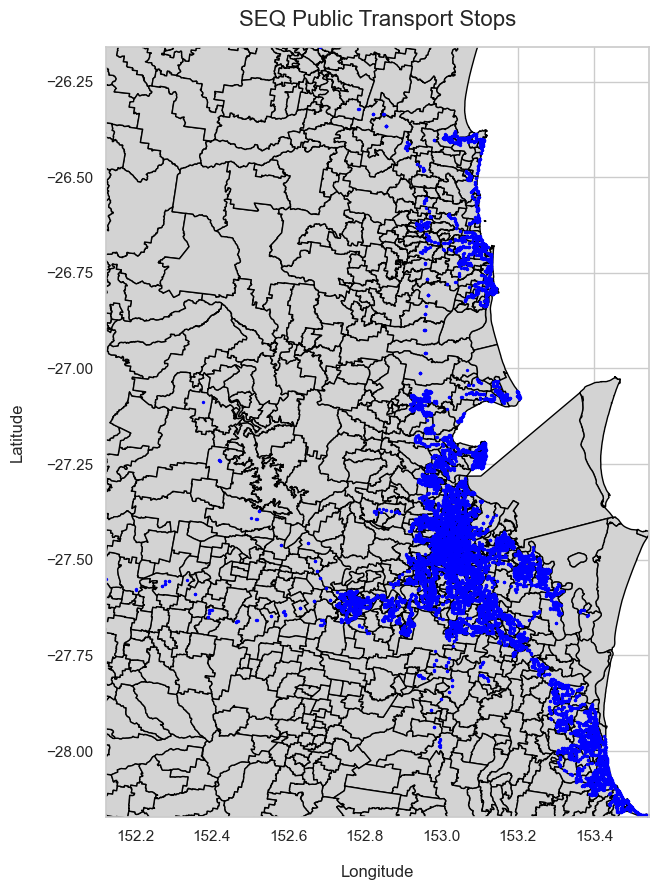

In [6]:
# Plotting the base map
ax = gdf_locality.plot(figsize=(10, 10), color='lightgrey', edgecolor='black')
gdf_stops.plot(ax=ax, color='blue', markersize=2)

# Adjust the axis limits to focus on bounding box of gdf_stops
minx, miny, maxx, maxy = gdf_stops.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Customize the plot as needed
plt.title('SEQ Public Transport Stops', fontsize=16, pad=15)
plt.xlabel('Longitude', labelpad=15)
plt.ylabel('Latitude', labelpad=15)

The query below is a left join to attach information about the locality and LGA that each stop is within. It is a spatial join that looks at where each point (a stop) is sitting within each polygon (the locality boundary). It also ensures that the stops geodataframe is representated in the same coordinate system as the boundaries geodataframe - this facilitates the spaitial join query.

In [7]:
# Setting the CRS
gdf_stops.crs = "EPSG:4326"
gdf_stops = gdf_stops.to_crs(epsg=4283)

# Left join stops data with locality data
stops_loc = gdf_stops.sjoin(gdf_locality, how="inner", predicate="within")
stops_loc.head()

# Reorder dataframe output and show
df_stops = stops_loc[['stop_id','stop_code','stop_name','stop_lat','stop_lon','zone_id','LOCALITY', 'LGA']]
df_stops

,stop_id,stop_code,stop_name,stop_lat,stop_lon,zone_id,LOCALITY,LGA
0,1,1,Herschel Street Stop 1 near North Quay,-27.467834,153.019079,1,Brisbane City,Brisbane City
1,10,10,Ann Street Stop 10 at King George Square,-27.468003,153.023970,1,Brisbane City,Brisbane City
2,100,100,Parliament Stop 94A Margaret St,-27.473751,153.026745,1,Brisbane City,Brisbane City
13,1001,1001,"Queen Street station, 1e",-27.470552,153.024575,1,Brisbane City,Brisbane City
22,1002,1002,"Queen Street station, 1f",-27.470675,153.024755,1,Brisbane City,Brisbane City
...,...,...,...,...,...,...,...,...
12047,600499,600499,"Traveston station, platform 1",-26.320895,152.783804,8,Traveston,Gympie Regional
12907,place_trvsta,-1,Traveston station,-26.321113,152.784072,NaN,Traveston,Gympie Regional
12049,600500,600500,"Gympie North station, platform 1",-26.159443,152.682805,8,Victory Heights,Gympie Regional
12835,place_gymsta,-1,Gympie North station,-26.159390,152.682995,NaN,Victory Heights,Gympie Regional


### An Example Query
We can now isoloate stops by their suburb.

In [8]:
df_stops[df_stops['LOCALITY'] == 'Bellbird Park']

,stop_id,stop_code,stop_name,stop_lat,stop_lon,zone_id,LOCALITY,LGA
5234,310169,310169,Keidges Rd at Redbank Plains High School,-27.649570,152.871274,3,Bellbird Park,Ipswich City
5235,310171,310171,Redbank Plains Rd at Frangipanni Street,-27.630331,152.880053,3,Bellbird Park,Ipswich City
5236,310172,310172,Redbank Plains Rd at Brennan Street,-27.627919,152.885395,3,Bellbird Park,Ipswich City
5237,310173,310173,Redbank Plains Rd at Jayvilla Court,-27.628259,152.883961,3,Bellbird Park,Ipswich City
5238,310174,310174,Redbank Plains Rd at Len Shearer Park,-27.632205,152.875841,3,Bellbird Park,Ipswich City
5239,310175,310175,Redbank Plains Rd at Len Shearer Park,-27.632299,152.875167,3,Bellbird Park,Ipswich City
5240,310176,310176,"Redbank Plains Town Square, stop B",-27.645224,152.872001,3,Bellbird Park,Ipswich City
5241,310177,310177,Redbank Plains Rd at Shannon Street,-27.634633,152.873819,3,Bellbird Park,Ipswich City
8470,317741,317741,Redbank Plains Rd at Barry Drive,-27.637790,152.873259,3,Bellbird Park,Ipswich City
8502,317797,317797,Jones Rd near Augusta Pkwy,-27.647373,152.877792,3,Bellbird Park,Ipswich City


### Adding Locality Information to Trip Data

In [9]:
# Adding in origin locality
df_trips = df_trips.merge(df_stops[['stop_code', 'LOCALITY']], left_on='origin_stop', right_on='stop_code', how='left')
df_trips.drop('stop_code', axis=1, inplace=True)
df_trips.rename(columns={'LOCALITY': 'origin_loc'}, inplace=True)

# Adding in destination locality
df_trips = df_trips.merge(df_stops[['stop_code', 'LOCALITY']], left_on='destination_stop', right_on='stop_code', how='left')
df_trips.drop('stop_code', axis=1, inplace=True)
df_trips.rename(columns={'LOCALITY': 'destination_loc'}, inplace=True)

# Reordering df
df_trips = df_trips[['operator','month','route','direction','time','ticket_type','origin_stop','origin_loc','destination_stop','destination_loc','quantity']]

df_trips

,operator,month,route,direction,time,ticket_type,origin_stop,origin_loc,destination_stop,destination_loc,quantity
0,Transport for Brisbane,2022-01,175,Outbound,Weekend,go card,10309,Greenslopes,2232,Mount Gravatt,1
1,Transport for Brisbane,2022-01,227,Outbound,Weekday (3:00pm-6:59:59pm),go card,228,Fortitude Valley,1308,Manly West,1
2,Transport for Brisbane,2022-01,227,Outbound,Weekday (3:00pm-6:59:59pm),go card,226,Fortitude Valley,6126,Manly West,4
3,Transport for Brisbane,2022-01,227,Outbound,Weekday (3:00pm-6:59:59pm),go card,226,Fortitude Valley,6027,Tingalpa,9
4,Transport for Brisbane,2022-01,227,Outbound,Weekday (3:00pm-6:59:59pm),go card,226,Fortitude Valley,5914,Murarrie,2
...,...,...,...,...,...,...,...,...,...,...,...
8835758,Transport for Brisbane,2023-08,192,Outbound,Weekday (3:00pm-6:59:59pm),go card,36,Brisbane City,1053,West End,6
8835759,Transport for Brisbane,2023-08,192,Outbound,Weekday (3:00pm-6:59:59pm),go card,36,Brisbane City,1051,West End,78
8835760,Transport for Brisbane,2023-08,192,Outbound,Weekday (3:00pm-6:59:59pm),go card,36,Brisbane City,1049,West End,41
8835761,Transport for Brisbane,2023-08,192,Outbound,Weekday (3:00pm-6:59:59pm),go card,36,Brisbane City,1128,West End,5


## Separating Origin and Destination Trip Data
This process will be of use for the future task of modelling demand at a given location.

However, the sourced datasets do not clearly show how many trips originate or terminate at a particular stop. We may wish to know this to understand questions such as "what is the busiest bus stop in the Brisbane CBD?" or "how did schedule works impact a given stop?".

The data can be aggregated by origin and destination to facilitate these queries.

In [10]:
df_trips_o = df_trips.groupby(['month', 'origin_stop','origin_loc'])['quantity'].sum().reset_index()
df_trips_o

,month,origin_stop,origin_loc,quantity
0,2022-01,1,Brisbane City,243
1,2022-01,2,Brisbane City,167
2,2022-01,3,Brisbane City,30
3,2022-01,4,Spring Hill,180
4,2022-01,5,Brisbane City,193
...,...,...,...,...
233194,2023-08,600829,Southport,35827
233195,2023-08,600831,Southport,61226
233196,2023-08,600832,Parkwood,6989
233197,2023-08,600834,Parkwood,19738


In [11]:
df_trips_d = df_trips.groupby(['month', 'destination_stop', 'destination_loc'])['quantity'].sum().reset_index()
df_trips_d

,month,destination_stop,destination_loc,quantity
0,2022-01,1,Brisbane City,350
1,2022-01,2,Brisbane City,758
2,2022-01,3,Brisbane City,1058
3,2022-01,4,Spring Hill,7
4,2022-01,5,Brisbane City,646
...,...,...,...,...
235889,2023-08,600829,Southport,37438
235890,2023-08,600831,Southport,56548
235891,2023-08,600832,Parkwood,6302
235892,2023-08,600834,Parkwood,18507


# Basic Trip Analysis
Some basic queries/analysis is shown below.

## Busiest periods
A plot showing the patronage by month shown below. The plot shows March 2023 as the busiest period in the dataset.

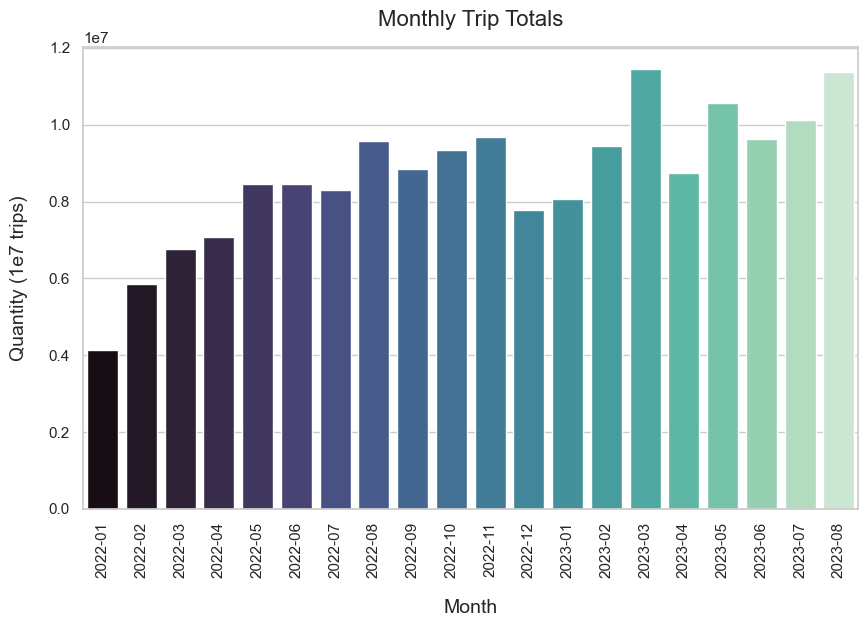

In [12]:
df_trip_totals = df_trips.groupby(['month'])['quantity'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='quantity', data=df_trip_totals, palette='mako')
plt.xticks(rotation=90)
plt.title('Monthly Trip Totals', fontsize=16, pad=15)
plt.xlabel('Month', fontsize=14, labelpad=15)
plt.ylabel('Quantity (1e7 trips)', fontsize=14, labelpad=15)

plt.show()

## Travel Between Localities
The top 20 origin-destination pairs for March 2023 (the busiest month in the dataset) are shown below.

In [13]:
# Filter results by March 2023
df_trip_mar23 = df_trips[df_trips['month'] == '2023-03']

df_trip_top20 = df_trip_mar23.groupby(['month', 'origin_loc', 'destination_loc'])['quantity'].sum().reset_index()
df_trip_top20 = df_trip_top20.sort_values(by='quantity', ascending=False).head(20)
df_trip_top20

,month,origin_loc,destination_loc,quantity
10815,2023-03,Southport,Southport,106079
10607,2023-03,South Brisbane,Brisbane City,104954
1785,2023-03,Brisbane City,South Brisbane,102238
1672,2023-03,Brisbane City,Fortitude Valley,76145
4666,2023-03,Fortitude Valley,Brisbane City,76091
1688,2023-03,Brisbane City,Herston,71828
5500,2023-03,Herston,Brisbane City,70656
10816,2023-03,Southport,Surfers Paradise,68390
11438,2023-03,Surfers Paradise,Broadbeach,67515
11455,2023-03,Surfers Paradise,Southport,64847


# Incorporating Census Data
Due to file size restrictions on GitHub, SA1 boundaries were processed offline (using GeoPandas) to select those within the Greater Brisbane region. This does not capture the entire geographic spread of stops in SEQ and will be updated in future revisions.
## Locating Stops Within SA1 Boundaries

In [14]:
gdf_SA1 = gpd.read_file("./spatial/SA1_boundaries.geojson")

A new geodataframe has been produced to create a points file for the stops. This is doubling up on prior code and will removed in future revisions to use the previous definition.

In [15]:
geometry = [Point(lon, lat) for lon, lat in zip(df_stops['stop_lon'], df_stops['stop_lat'])]
gdf_stops = gpd.GeoDataFrame(df_stops, geometry=geometry)
gdf_stops

,stop_id,stop_code,stop_name,stop_lat,stop_lon,zone_id,LOCALITY,LGA,geometry
0,1,1,Herschel Street Stop 1 near North Quay,-27.467834,153.019079,1,Brisbane City,Brisbane City,POINT (153.01908 -27.46783)
1,10,10,Ann Street Stop 10 at King George Square,-27.468003,153.023970,1,Brisbane City,Brisbane City,POINT (153.02397 -27.46800)
2,100,100,Parliament Stop 94A Margaret St,-27.473751,153.026745,1,Brisbane City,Brisbane City,POINT (153.02675 -27.47375)
13,1001,1001,"Queen Street station, 1e",-27.470552,153.024575,1,Brisbane City,Brisbane City,POINT (153.02457 -27.47055)
22,1002,1002,"Queen Street station, 1f",-27.470675,153.024755,1,Brisbane City,Brisbane City,POINT (153.02475 -27.47067)
...,...,...,...,...,...,...,...,...,...
12047,600499,600499,"Traveston station, platform 1",-26.320895,152.783804,8,Traveston,Gympie Regional,POINT (152.78380 -26.32090)
12907,place_trvsta,-1,Traveston station,-26.321113,152.784072,NaN,Traveston,Gympie Regional,POINT (152.78407 -26.32111)
12049,600500,600500,"Gympie North station, platform 1",-26.159443,152.682805,8,Victory Heights,Gympie Regional,POINT (152.68281 -26.15944)
12835,place_gymsta,-1,Gympie North station,-26.159390,152.682995,NaN,Victory Heights,Gympie Regional,POINT (152.68300 -26.15939)


In [18]:
# Resetting index for joins
gdf_stops = gdf_stops.reset_index(drop=True)
gdf_SA1 = gdf_SA1.reset_index(drop=True)

In [19]:
# Confirming CRS of joined geodataframes
print("CRS of gdf_stops:", gdf_stops.crs)
print("CRS of gdf_SA1:", gdf_SA1.crs)

CRS of gdf_stops: None
CRS of gdf_SA1: EPSG:4283


In [24]:
# Setting the CRS
gdf_stops.crs = "EPSG:4326"
gdf_stops = gdf_stops.to_crs(epsg=4283)

# Left join stops data with SA1 boundaries
stops_SA1 = gdf_stops.sjoin(gdf_SA1, how="inner", predicate="within", lsuffix='_left', rsuffix='_right')
stops_SA1.head()

# Reorder geodataframe output and show
stops_SA1 = stops_SA1[['stop_id','stop_code','stop_name','stop_lat','stop_lon','zone_id','LOCALITY', 'LGA', 'SA1_CODE21']]
stops_SA1

,stop_id,stop_code,stop_name,stop_lat,stop_lon,zone_id,LOCALITY,LGA,SA1_CODE21
0,1,1,Herschel Street Stop 1 near North Quay,-27.467834,153.019079,1,Brisbane City,Brisbane City,30501110528
32,119,119,George Street Stop 119 near Tank St CLOSING 17...,-27.467685,153.020271,1,Brisbane City,Brisbane City,30501110528
34,120,120,George Street Stop 120 CLOSING 17 NOV,-27.467476,153.020072,1,Brisbane City,Brisbane City,30501110528
59,2,2,Herschel Street Stop 2 near North Quay,-27.468095,153.018744,1,Brisbane City,Brisbane City,30501110528
1,10,10,Ann Street Stop 10 at King George Square,-27.468003,153.023970,1,Brisbane City,Brisbane City,30501110536
...,...,...,...,...,...,...,...,...,...
12999,place_walsta,-1,Walloon station,-27.607215,152.667634,NaN,Walloon,Ipswich City,31002128227
13000,600360,600360,"Thagoona station, platform 1",-27.626825,152.629976,4,Thagoona,Ipswich City,31002128232
13001,600361,600361,"Thagoona station, platform 2",-27.626865,152.629895,4,Thagoona,Ipswich City,31002128232
13002,place_thasta,-1,Thagoona station,-27.626391,152.630755,NaN,Thagoona,Ipswich City,31002128232


## Reading in Census Data
This preliminary analysis considers 2021 census data obtained from the Place of Enumeration Profile. Additional statistics will be incorporated in future revisions.

In [42]:
PEP_P02 = pd.read_csv('./data/2021Census_P02_QLD_SA1.csv')
PEP_P02 = PEP_P02[['SA1_CODE_2021', 'Median_age_persons', 'Med_mort_repaymnt_monthly', 'Median_rent_weekly', 'Med_tot_hh_incom_weekly', 'Average_household_size']]
PEP_P02['SA1_CODE_2021'] = PEP_P02['SA1_CODE_2021'].astype(str)
PEP_P02

,SA1_CODE_2021,Median_age_persons,Med_mort_repaymnt_monthly,Median_rent_weekly,Med_tot_hh_incom_weekly,Average_household_size
0,30101100101,48,1820,423,2725,3.0
1,30101100102,36,1950,420,2250,2.9
2,30101100103,42,1950,355,2059,2.8
3,30101100104,43,1950,480,2187,2.7
4,30101100105,41,1733,220,1170,2.5
...,...,...,...,...,...,...
12543,31905152612,46,1717,300,1797,2.8
12544,31905152613,46,1500,360,1978,2.8
12545,39797979991,49,0,0,0,0.0
12546,39797979992,64,0,0,2250,0.0


## Demonstrative Analysis on March 2023 Origin Trips
In the future, a time-series analysis will be undertaken to understand seasonalities and whether elements such as temperature can affect demand.

For this preliminary revision, data relating to trip origins has been aggregated by SA1 boundaries within a selection of suburbs for demonstrating basic analysis. The suburbs chosen are:

*Annerley, Yeronga, Tarragindi, Moorooka, Greenslopes, Lutwyche, Gordon Park, Clayfield, Wilston, Grange, Indooroopilly, Chapel Hill and Taringa.*

This may help to understand if SA1 level statistics will be suitable for modelling demand.



In [50]:
suburb_list = ['Annerley', 'Yeronga', 'Tarragindi', 'Moorooka', 'Greenslopes', 'Lutwyche', 'Gordon Park', 'Clayfield', 'Wilston', 'Grange', 'Indooroopilly', 'Chapel Hill', 'Taringa']

# Filter results by March 2023 and suburbs
df_mar23_agg = df_trips_o[(df_trips_o['month'] == '2023-03') & df_trips_o['origin_loc'].isin(suburb_list)]
df_mar23_agg = df_mar23_agg.merge(stops_SA1[['stop_code', 'SA1_CODE21']], left_on='origin_stop', right_on='stop_code', how='left')
df_mar23_agg.drop('stop_code', axis=1, inplace=True)

df_mar23_agg = df_mar23_agg.groupby('SA1_CODE21')['quantity'].sum().reset_index()

# Add in Census Data

df_mar23_agg = df_mar23_agg.merge(PEP_P02, left_on='SA1_CODE21', right_on='SA1_CODE_2021', how='left')

df_mar23_agg = df_mar23_agg[['SA1_CODE_2021', 'Median_age_persons', 'Med_mort_repaymnt_monthly', 'Median_rent_weekly', 'Med_tot_hh_incom_weekly', 'Average_household_size', 'quantity']]
df_mar23_agg


,SA1_CODE_2021,Median_age_persons,Med_mort_repaymnt_monthly,Median_rent_weekly,Med_tot_hh_incom_weekly,Average_household_size,quantity
0,30202103101,37,2492,390,2370,2.5,609
1,30202103102,35,2055,340,2170,2.1,290
2,30202103103,34,1700,375,2029,2.2,561
3,30202103125,34,1853,350,1833,2.0,11
4,30202103127,36,2084,350,2217,2.4,2725
...,...,...,...,...,...,...,...
221,30503113127,31,2600,360,1970,2.1,126
222,30503113128,29,1892,430,2009,1.8,14339
223,30503113129,30,1101,305,1105,1.5,3677
224,30504113705,39,3000,490,3274,2.8,92


A correlation matrix has been produced to understand whether any of these incorporated statistics have any correlation to demand (trip quantity).

<function matplotlib.pyplot.show(close=None, block=None)>

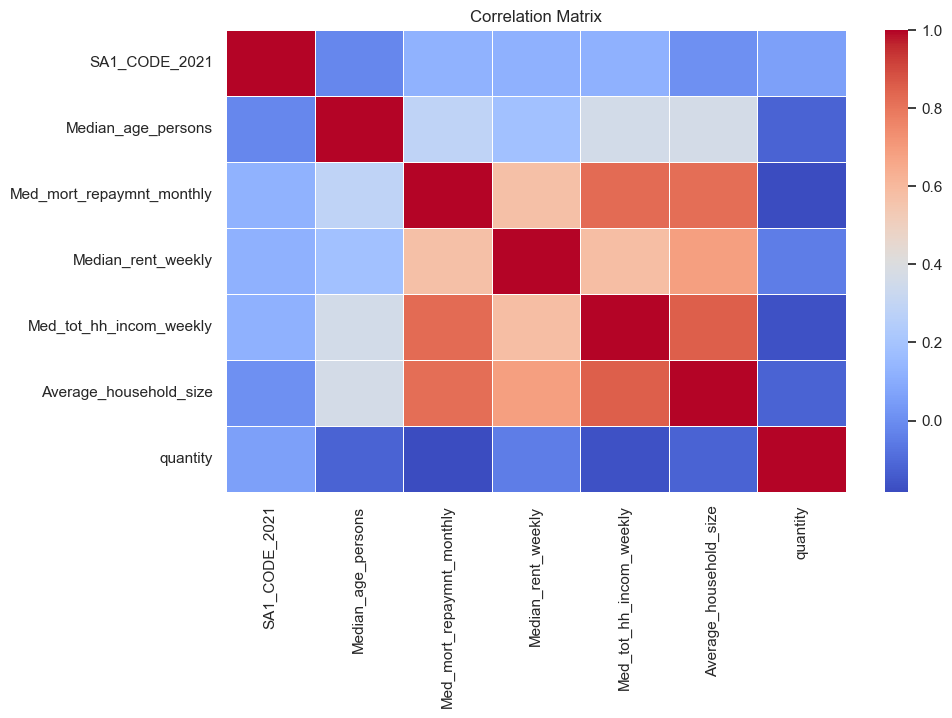

In [61]:
# Make correlation matrix
correlation_matrix = df_mar23_agg.corr()

# Plot a pretty figure
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show

In [62]:
# Focus on correlation with quantity
quantity_corr = correlation_matrix['quantity']
print(quantity_corr)

SA1_CODE_2021                0.058022
Median_age_persons          -0.121971
Med_mort_repaymnt_monthly   -0.182972
Median_rent_weekly          -0.047841
Med_tot_hh_incom_weekly     -0.164823
Average_household_size      -0.121227
quantity                     1.000000
Name: quantity, dtype: float64


### Observations
The correlation coefficients are generally close to zero or indicate weak correlations of the census data with trip demand. However, it's important to note that correlation does not imply causation. Even if the correlation is weak, it doesn't necessarily mean that changes in one variable cause changes in another. Additionally, non-linear relationships, outliers, or confounding factors may impact the interpretation of these correlations.

Further work is needed to incorporate additional data that may have more correlation with trip demand.

# Future Work
This notebook file shows the lead-up work to developing a tool to model demand for public transport. Future iterations will incorporate machine learning to predict demand for bus stops. The following will be undertaken:
- Incorporation of additional data e.g. weather, economic measures, car ownership
- Additional statistical analysis e.g. correlation analysis investigating elements such as car ownership vs patronage